# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [ ]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


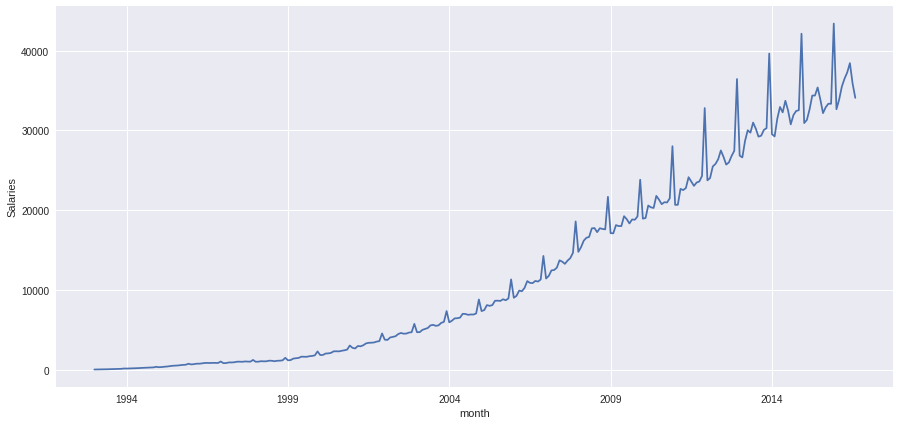

In [ ]:
raw = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
raw.WAG_C_M.plot()
plt.ylabel('Salaries')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 936x720 with 0 Axes>

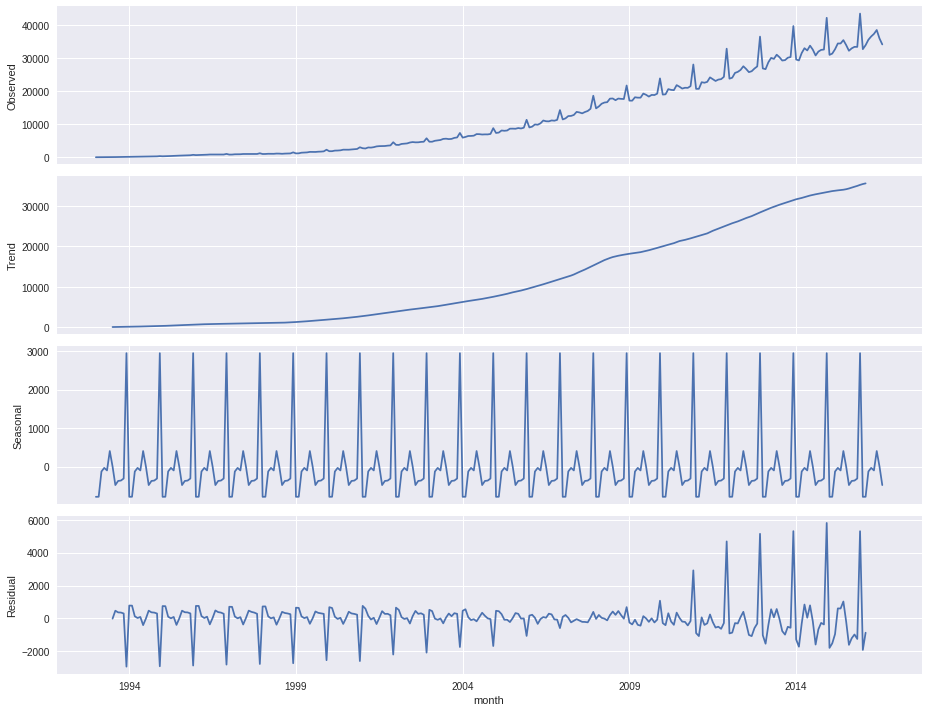

In [ ]:
plt.figure(figsize(13,10))
sm.tsa.seasonal_decompose(raw.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(raw.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


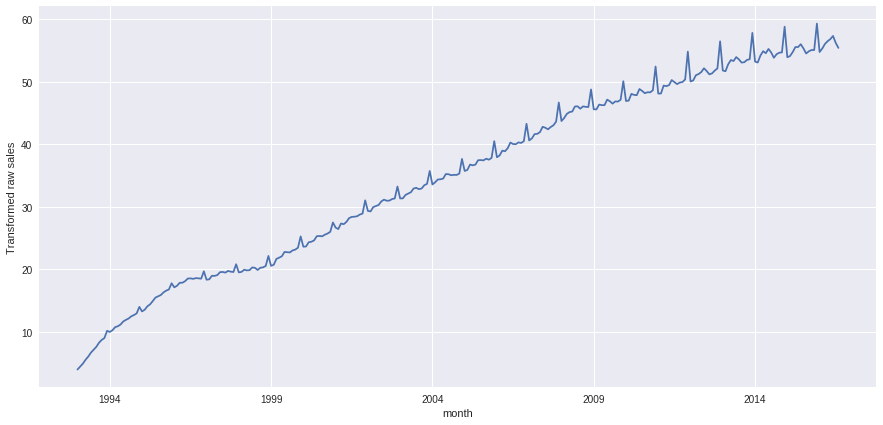

In [10]:
raw['salary_box'], lmbda = stats.boxcox(raw.WAG_C_M)
plt.figure(figsize(15,7))
raw.salary_box.plot()
plt.ylabel(u'Transformed raw sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(raw.salary_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

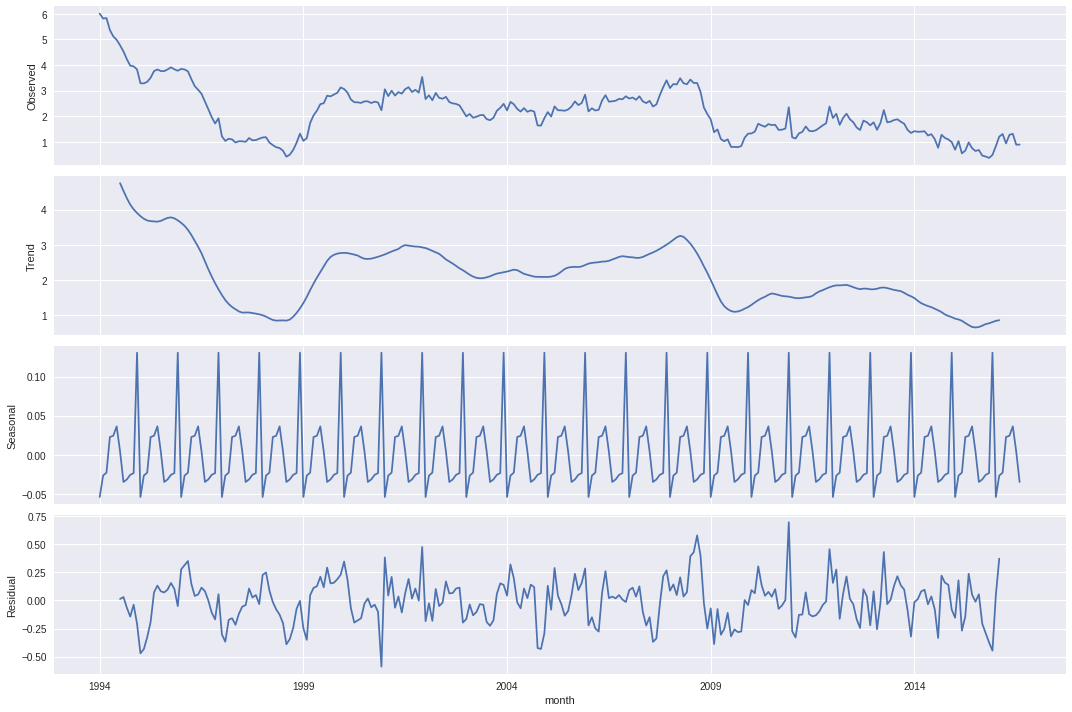

In [11]:
raw['salary_box_diff'] = raw.salary_box - raw.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(raw.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(raw.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

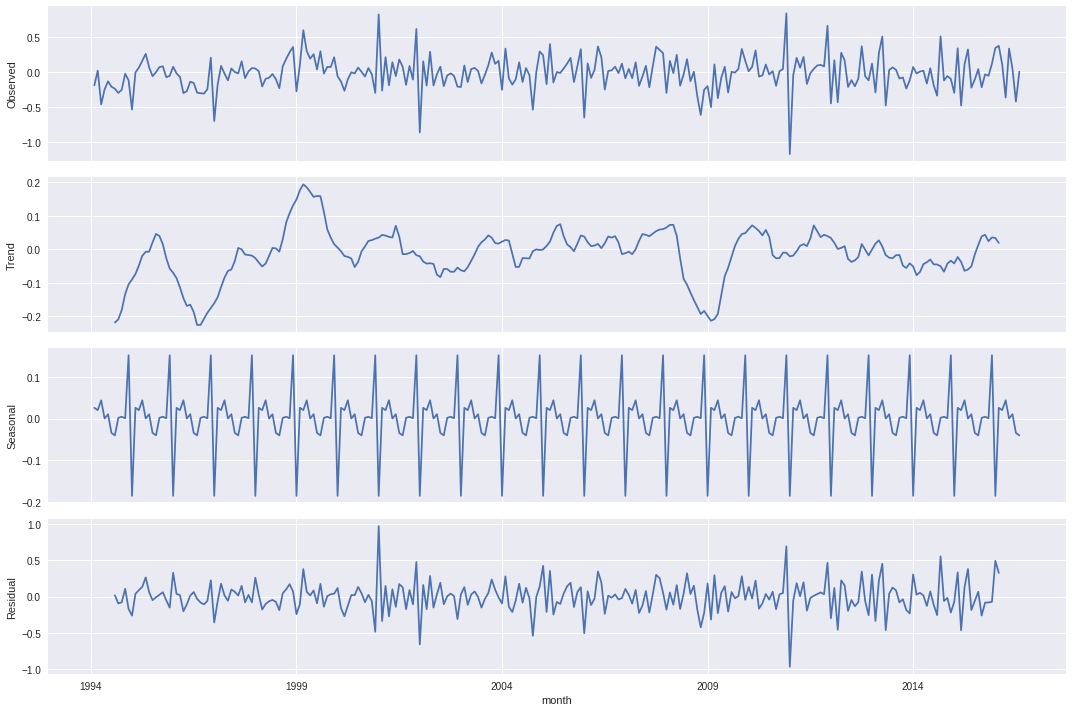

In [12]:
raw['salary_box_diff2'] = raw.salary_box_diff - raw.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(raw.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(raw.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

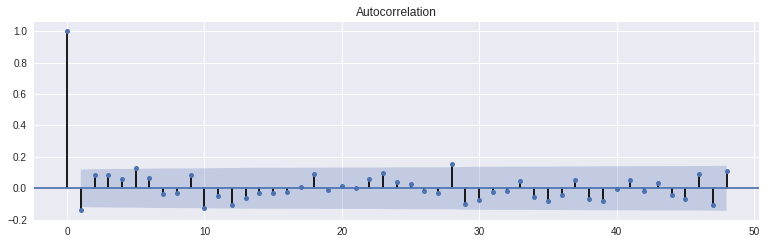

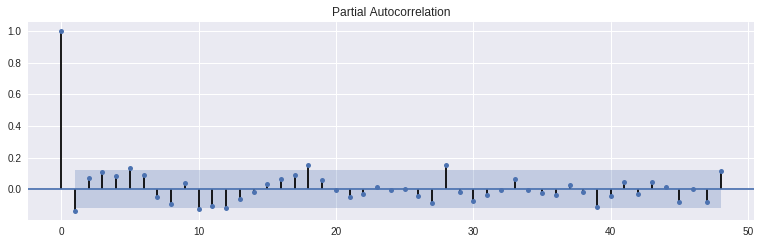

In [14]:
plt.figure(figsize(13,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(raw.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(raw.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=5, P=1, p=5

In [ ]:
ps = range(0, 1)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 6)

In [24]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [25]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(raw.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    print('good parameters:', param)
    except ValueError:
        print('!wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
CPU times: user 18min 30s, sys: 14min 26s, total: 32min 57s
Wall time: 16min 33s


In [26]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
66  (0, 5, 1, 1) -10.191522
65  (0, 5, 1, 0)  -9.803173
69  (0, 5, 1, 4)  -9.388551
64  (0, 5, 0, 5)  -8.828835
60  (0, 5, 0, 1)  -8.778902


Лучшая модель:

In [27]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(0, 1, 5)x(1, 1, 1, 12)   Log Likelihood                  13.096
Date:                            Fri, 05 Apr 2019   AIC                            -10.192
Time:                                    14:46:03   BIC                             19.000
Sample:                                01-01-1993   HQIC                             1.512
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2469      0.048     -5.139      0.000      -0.341      -0.153
ma.L2          0.0586      0.076   

Её остатки:

Критерий Стьюдента: p=0.174402
Критерий Дики-Фуллера: p=0.000000


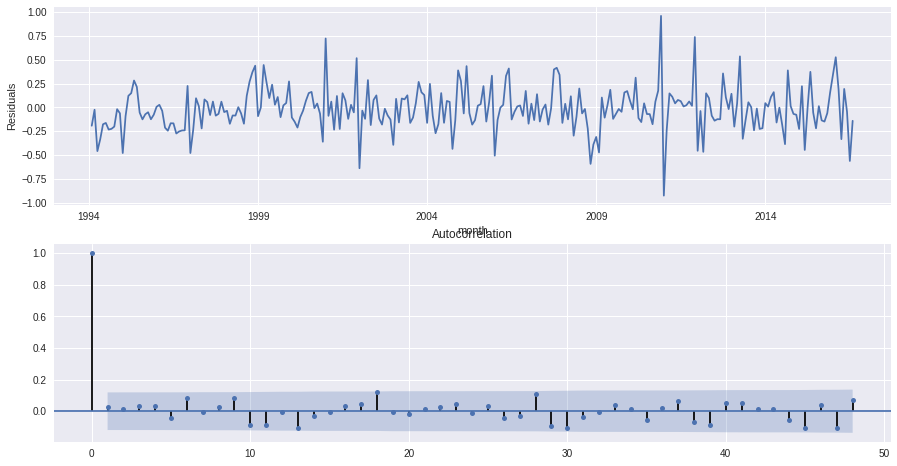

In [28]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

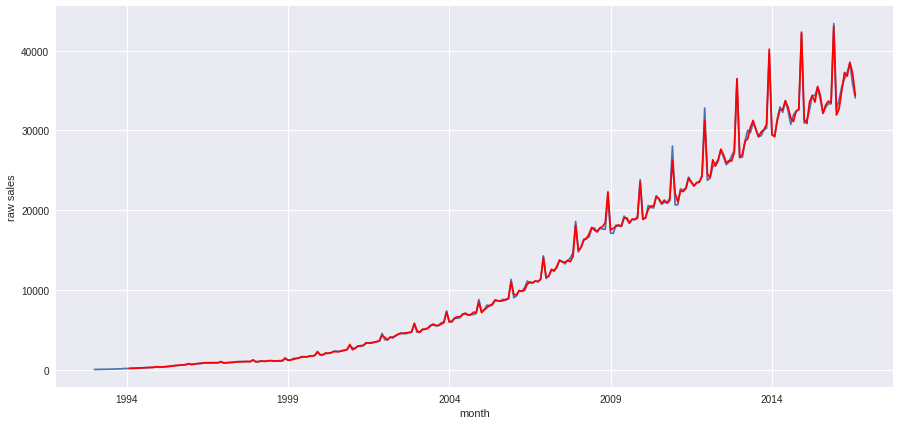

In [30]:
raw['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
raw.WAG_C_M.plot()
raw.model[13:].plot(color='r')
plt.ylabel('raw sales')
pylab.show()

### Прогноз

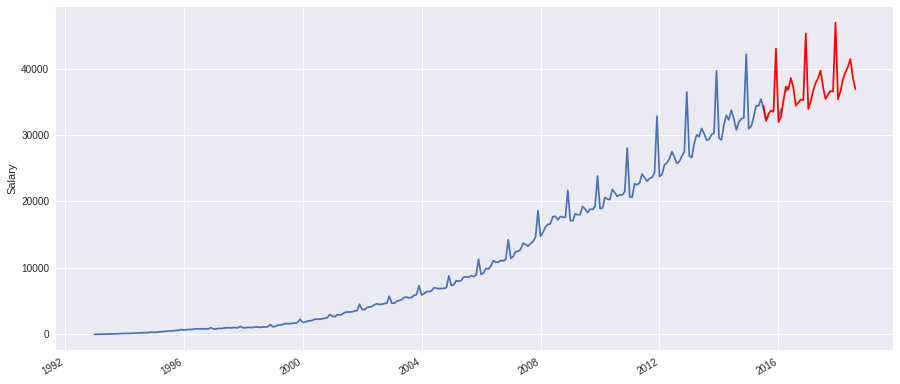

In [38]:
raw2 = raw[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2015-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= raw2.columns)
raw2 = pd.concat([raw2, future])
raw2['forecast'] = invboxcox(best_model.predict(start=270, end=320), lmbda)

plt.figure(figsize(15,7))
raw2.WAG_C_M.plot()
raw2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()